In [1]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import datetime
from urllib.request import urlopen, Request
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests

In [54]:
#CONFIGURATION
COMPANY = "nvidia-corp"

In [55]:
import cloudscraper
from bs4 import BeautifulSoup
import time
import random

scraper = cloudscraper.create_scraper(
    browser={
        'browser': 'chrome',
        'platform': 'windows',
        'mobile': False
    },
    delay=2
)

url = f'https://www.investing.com/equities/{COMPANY}-financial-summary'

time.sleep(random.uniform(1, 3))

try:
    response = scraper.get(url)
    
    if response.status_code == 200:
        print(f"Successfully retrieved: {response.status_code}")
        soup = BeautifulSoup(response.content, 'html.parser')
        sheet = soup.find(class_="min-w-0")
    else:
        print(f"Failed to retrieve: {response.status_code}")
except Exception as e:
    print(f"Error: {e}")

Successfully retrieved: 200


In [57]:
ticker = sheet.find("h1").text.split('(')[1].strip().replace(')', '')
current_price = sheet.find(class_="text-5xl/9 font-bold text-[#232526] md:text-[42px] md:leading-[60px]").text
percent_change = sheet.find("span", {'data-test': 'instrument-price-change-percent'}).text
p_e_ratio = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[0].text
price_book_ratio = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[1].text
debt_equity_ratio = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[2].text
return_on_equity = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[3].text
dividend_yield = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[4].text
ebitda_margin = sheet.find_all("span", class_="block text-sm leading-5 rtl:text-right rtl:soft-ltr")[5].text
#check if the 5-year element exists before accessing it
if len(sheet.find_all("div", class_="font-['Inter'] text-sm font-semibold leading-tight text-[#181c21] !text-[#007C32]")) > 0:
    five_years_growth = sheet.find_all("div", class_="font-['Inter'] text-sm font-semibold leading-tight text-[#181c21] !text-[#007C32]")[0].text
else:
    five_years_growth = "N/A"

In [58]:
print(f'Ticker : {ticker}')
print(f'Current Price : {current_price} {percent_change}')
print(f'P/E Ratio : {p_e_ratio}')
print(f'Price/Book Ratio : {price_book_ratio}')
print(f'Debt/Equity Ratio : {debt_equity_ratio}')
print(f'Return on Equity : {return_on_equity}')
print(f'Dividend Yield : {dividend_yield}')
print(f'EBITDA Margin : {ebitda_margin}')
print(f'5 Years Growth : {five_years_growth}')

Ticker : NVDA
Current Price : 134.38 (-0.88%)
P/E Ratio : 45.49
Price/Book Ratio : 41.76
Debt/Equity Ratio : 12.95%
Return on Equity : 119.18%
Dividend Yield : 0.03%
EBITDA Margin : 83.32B
5 Years Growth : +16.27%


In [59]:
table = soup.find(class_="w-full text-xs leading-4 indicators-table_table__lfa5n indicators-table_table--freeze-column__MonUl")
thead = table.find('thead')
years=[]
for th in thead.find_all('th',class_="indicators-table_cell__m6pYi min-w-[100px] border-b border-[#D9DCDF] py-2.5 pr-3 text-right !text-xs font-normal rtl:text-right"):
    year=th.find('div', class_='font-semibold').text
    years.append(year)

In [60]:
years=years[5:]

In [61]:
columns = [col.text.strip() for col in table.find_all('div', class_="overflow-hidden text-ellipsis whitespace-nowrap")]
columns = [col for col in columns if col not in ['Income Statement', 'Balance Sheet', 'Cash Flow']]
print(columns)

['Total Revenues', 'Gross Profit', 'Operating Income', 'Net Income', 'Total Assets', 'Total Current Liabilities', 'Total Equity', 'Levered Free Cash Flow', 'Cash from Operations', 'Cash from Investing', 'Cash from Financing', 'Net Change in Cash']


In [62]:
statements_df= pd.DataFrame(columns=columns, index=years)

In [63]:
statements_df

,Total Revenues,Gross Profit,Operating Income,Net Income,Total Assets,Total Current Liabilities,Total Equity,Levered Free Cash Flow,Cash from Operations,Cash from Investing,Cash from Financing,Net Change in Cash
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
total_value = [
	float(col.text.strip().replace(',', '').replace('−', '-').replace('–', '-'))
	for col in table.find_all('td', class_="indicators-table_cell__m6pYi whitespace-nowrap py-2.5 pr-3 text-right min-w-[100px] border-b border-[#D9DCDF] font-normal")
]
total_revenue = total_value[0:len(years)]
gross_profit = total_value[len(years):len(years)*2]
operating_income = total_value[len(years)*2:len(years)*3]
net_income = total_value[len(years)*3:len(years)*4]
total_assets = total_value[len(years)*4:len(years)*5]
total_liabilities = total_value[len(years)*5:len(years)*6]
total_equity = total_value[len(years)*6:len(years)*7]
levered_free_cash_flow = total_value[len(years)*7:len(years)*8]
cash_from_operations = total_value[len(years)*8:len(years)*9]
cash_from_investing = total_value[len(years)*9:len(years)*10]
cash_from_financing = total_value[len(years)*10:len(years)*11]
net_change_cash = total_value[len(years)*11:len(years)*12]

In [65]:
#fill the dataframe with the values
statements_df.loc[:, 'Total Revenues'] = total_revenue
statements_df.loc[:, 'Gross Profit'] = gross_profit
statements_df.loc[:, 'Operating Income'] = operating_income
statements_df.loc[:, 'Net Income'] = net_income
statements_df.loc[:, 'Total Assets'] = total_assets
statements_df.loc[:, 'Total Current Liabilities'] = total_liabilities
statements_df.loc[:, 'Total Equity'] = total_equity
statements_df.loc[:, 'Levered Free Cash Flow'] = levered_free_cash_flow
statements_df.loc[:, 'Cash from Operations'] = cash_from_operations
statements_df.loc[:, 'Cash from Investing'] = cash_from_investing
statements_df.loc[:, 'Cash from Financing'] = cash_from_financing
statements_df.loc[:, 'Net Change in Cash'] = net_change_cash

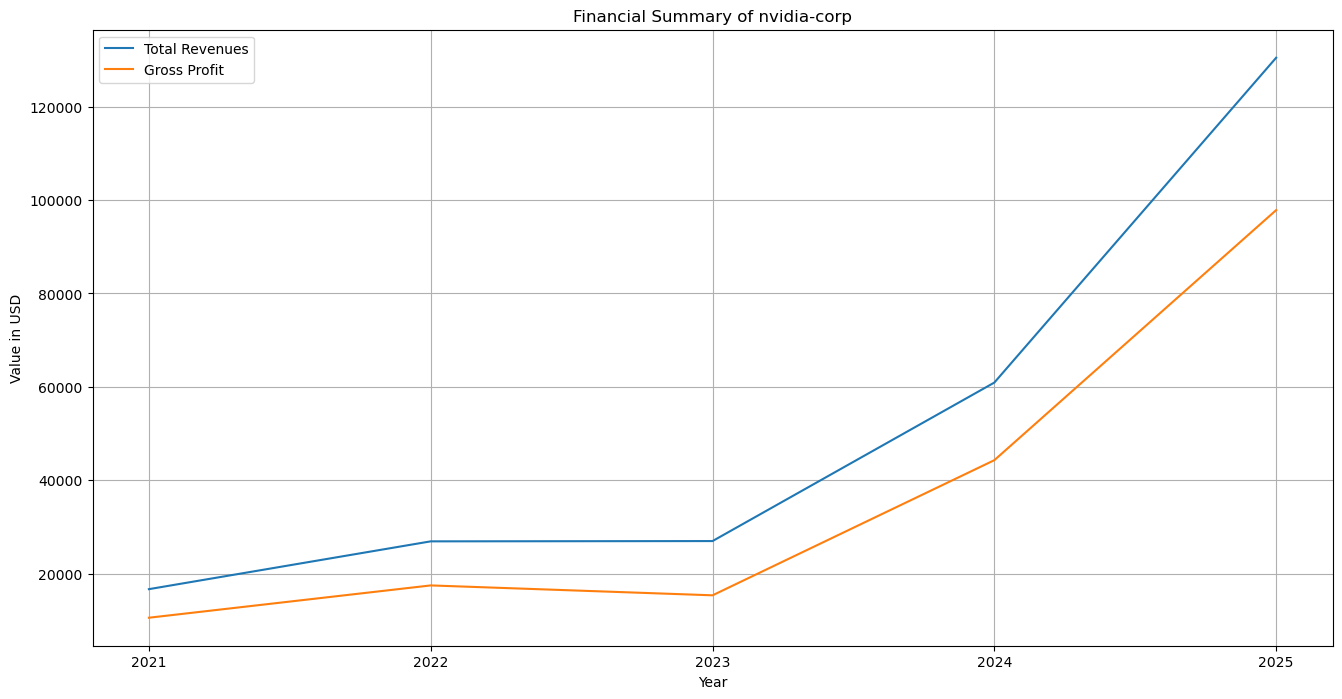

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(data=statements_df, x=statements_df.index, y='Total Revenues', label='Total Revenues')
sns.lineplot(data=statements_df, x=statements_df.index, y='Gross Profit', label='Gross Profit')
plt.xlabel('Year')
plt.ylabel('Value in USD')
plt.title(f'Financial Summary of {COMPANY}')
plt.legend()
plt.grid()
plt.show()

In [68]:
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
statements_df.to_csv(f"Data/Financials/{ticker}_{date_time}.csv", index=False)